# Initialization

In [1]:
import os
import sys
print(sys.executable)    # vérification
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable



/Users/gaelleba/anaconda3/envs/sparkEnv/bin/python


In [2]:

import pyspark
from pyspark.sql import SparkSession
import sparknlp
sparknlp.start()

#pip install --upgrade spark-nlp
print(sparknlp.version())

:: loading settings :: url = jar:file:/Users/gaelleba/anaconda3/envs/sparkEnv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/gaelleba/.ivy2/cache
The jars for the packages stored in: /Users/gaelleba/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-fe3fb0db-ef20-4e7d-a233-44e76a07a22c;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.5.1 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in 

5.5.1


In [14]:
import pandas as pd
wd=!pwd
path=wd[0]
source_file=f'{path}/unique_abstracts_dates.csv'
df_abstracts=pd.read_csv(source_file, sep='\t', header=0)


In [15]:

def extract_year(pubdate):
    year = pubdate.strip("[]").split(',')[0]
    return int(year.strip("'"))

df_abstracts['Year'] = df_abstracts['Pubdate'].apply(extract_year)
#df_abstracts.info()
abstracts = df_abstracts["Abstract"].tolist()
years = df_abstracts["Year"].astype(int).tolist()

In [18]:
from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import udf
spark = SparkSession.builder.getOrCreate()

# Define the schema
schema = StructType([
    StructField("abstract", StringType(), True),
    StructField("year", IntegerType(), True)
])

# Create DataFrame
data = [(abstracts[i], years[i]) for i in range(len(df_abstracts))]
Sptext = spark.createDataFrame(data, schema=schema)
Sptext.show(10)

## Create Full data frame
full = spark.read.format("csv").option("header", True) \
.option("sep", "\t") \
.load(source_file)
full.show(10)

full = full.join(Sptext, on="abstract").drop("Pubdate")
full.show(10)

+--------------------+----+
|            abstract|year|
+--------------------+----+
|It has been firml...|2014|
|Although the asso...|2006|
|This study examin...|2014|
|The electrophysio...|2014|
|Time-of-day effec...|2000|
|Epidemiological a...|2017|
|TMS combined with...|2007|
|The aim of the pr...|2003|
|The authors studi...|2010|
|Despite the subje...|2018|
+--------------------+----+
only showing top 10 rows

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------------+--------+---------------+
|               Title|                 DOI|            Abstract|          MeSH_Terms|         Pubmed link|drug_name_list|pubchem_id_list|    PMID|        Pubdate|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------------+--------+---------------+
|Oscillatory spati...|DOI: 10.1016/j.al...|It has been firml...|['Adult', 'Alcoho...|https://

# Pre-traitement 

In [19]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import Pipeline
from sparknlp.pretrained import PretrainedPipeline

# Assemblage du document
documentAssembler = DocumentAssembler() \
                      .setCleanupMode("inplace") \
                      .setInputCol("Abstract") \
                      .setOutputCol("document")

# Tokenisation
tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')
    # suppression des caracteres spéciaux tout en gardant les expressions alphanumériques

# Normalisation
normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("normalized") \
        .setLowercase(True) \
        .setCleanupPatterns(["""[^a-zA-Z\s]"""]) # remove all non-alphabetic characters

# Lemmatisation
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma')

# Suppression des mots vides
stopwords_cleaner = StopWordsCleaner.pretrained() \
    .setInputCols(['lemma']) \
    .setOutputCol('clean_lemma')


finisher = Finisher() \
    .setInputCols(["clean_lemma"])\
    .setOutputCols("output")

# Pipeline
pipeline_lemma = Pipeline(stages=[
    documentAssembler,
    tokenizer,
    normalizer,
    lemmatizer,
    stopwords_cleaner,
    finisher
])
    
# Application du pipeline
model_lemma = pipeline_lemma.fit(full)
result_lemma = model_lemma.transform(full)
result_lemma.printSchema()
result_lemma.select("Title", "output").show(10, 300)

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ym/bgkz_f9x4f7dygsy5ydxzyb80000gn/T/ipykernel_30895/2301054594.py:25: SyntaxWarning: invalid escape sequence '\s'
  .setCleanupPatterns(["""[^a-zA-Z\s]"""]) # remove all non-alphabetic characters


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]

25/01/17 10:53:38 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/01/17 10:53:38 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[OK!]
stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[ | ]

25/01/17 10:53:43 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/01/17 10:53:43 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/01/17 10:53:44 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
Download done! Loading the resource.


25/01/17 10:53:45 WARN StopWordsCleaner: Default locale set was [en_CH]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


[OK!]
root
 |-- Abstract: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- DOI: string (nullable = true)
 |-- MeSH_Terms: string (nullable = true)
 |-- Pubmed link: string (nullable = true)
 |-- drug_name_list: string (nullable = true)
 |-- pubchem_id_list: string (nullable = true)
 |-- PMID: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- output: array (nullable = true)
 |    |-- element: string (containsNull = true)

+-----------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                            

# Encodage TF-IDF des lemmes

In [20]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.sql.functions import udf, col, explode

vocab_size = 1000
# Create a CountVectorizer model with the specified parameters
cv = CountVectorizer(inputCol="output", outputCol="rawFeatures", vocabSize=vocab_size, minDF=20, maxDF=0.4)
cv_model = cv.fit(result_lemma)

# Calcul des valeurs IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Pipeline
pipeline_tf_idf = Pipeline(stages=[
    cv,
    idf
])

# Application du pipeline
model_tfidf = pipeline_tf_idf.fit(result_lemma)
result_tfidf = model_tfidf.transform(result_lemma)
result_tfidf.select("Abstract", "output", "rawFeatures", "features").show(10, 100)


+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                            Abstract|                                                                                              output|                                                                                         rawFeatures|                                                                                            features|
+----------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------

# LDA 

In [21]:
from pyspark.ml.clustering import LDA

# Apply LDA
num_topics = 5
max_iterations = 200
random_seed = 42
lda = LDA(k=num_topics, maxIter=max_iterations, featuresCol="features").setSeed(random_seed)
lda_model = lda.fit(result_tfidf)

# Describe Topics
topics = lda_model.describeTopics(maxTermsPerTopic=10)
topics.show(truncate=False)

# Transform to show topic distribution
transformed = lda_model.transform(result_tfidf)
transformed.select("Title", "topicDistribution").show(truncate=False)

25/01/17 10:55:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+-----+------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                     |termWeights                                                                                                                                                                                                                 |
+-----+------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[138, 107, 83, 50, 118, 201, 7, 256, 4, 100]    |[0.013010123110981583, 0.012531858669348164, 0.011287273115892305, 0.009708930655052184, 0.009250612227038843,

In [22]:
import pyspark.sql.functions as f
from pyspark.sql.types import ArrayType, StringType


# get (tokenized) vocabulary mapping to trace back topics later
terms = cv_model.vocabulary

# get topics
topics_df = lda_model.describeTopics(maxTermsPerTopic=10)
# define udf to map term indices to original token from count vectorizer vocabulary
@f.udf(returnType=ArrayType(StringType()))
def indices_to_terms(indices, terms=terms):
    terms_mapping = [terms[index] for index in indices]
    return terms_mapping

# apply udf to generate topic idx to token mapping
topics_df = topics_df.withColumn("termValues", indices_to_terms(f.col("termIndices")))
print("The topics described by their top-weighted terms:")
topics_df.select("topic", "termValues").show(truncate=False)


The topics described by their top-weighted terms:


+-----+----------------------------------------------------------------------------------------------+
|topic|termValues                                                                                    |
+-----+----------------------------------------------------------------------------------------------+
|0    |[component, pain, network, hz, baseline, connectivity, brain, gamma, activity, rem]           |
|1    |[patient, group, epilepsy, seizure, alpha, child, control, temporal, brain, ad]               |
|2    |[sleep, mg, dose, night, placebo, motor, concentration, administration, perform, min]         |
|3    |[task, process, visual, stimulus, memory, amplitude, cognitive, attention, performance, learn]|
|4    |[beta, method, receptor, describe, gene, paradigm, involve, gate, genotype, wave]             |
+-----+----------------------------------------------------------------------------------------------+



# Analyse sémantique latente: PCA 

In [23]:
from pyspark.ml.feature import PCA

# Décomposition en valeurs singulières (SVD)
pca = PCA(k=3, inputCol="features", outputCol="PCA_Features")

# Application du pipeline avec SVD
model_pca = pca.fit(transformed)
result_pca = model_pca.transform(transformed)
result_pca.select("Title", "PCA_Features").show(10, 100)

25/01/17 10:55:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+----------------------------------------------------------------------------------------------------+--------------------------------------------------------------+
|                                                                                               Title|                                                  PCA_Features|
+----------------------------------------------------------------------------------------------------+--------------------------------------------------------------+
|Oscillatory spatial profile of alcohol's effects on the resting state: anatomically-constrained MEG.| [-1.1009080082619414,-17.430116468084453,-0.4103843096027241]|
|              Effects of alcohol on sleep and the sleep electroencephalogram in healthy young women.| [-7.283583781755468,-0.49081566346015126,-2.1093580314973837]|
|Spatio-temporal processing of words and nonwords: hemispheric laterality and acute alcohol intoxi...| [-0.39054548314656945,-9.171072987298636,-2.4109173492979386]|
|Alc

In [24]:
from pyspark.sql.functions import length

# Calculate the length of the abstract
result_pca = result_pca.withColumn("AbstractLength", length("Abstract"))
# Select necessary columns
data = result_pca.select("Title", "Year", "AbstractLength", "PCA_Features")
# Convert to Pandas DataFrame
pandas_df = data.toPandas()
# Extract PCA features into separate columns
pandas_df[['PCA1', 'PCA2', 'PCA3']] = pd.DataFrame(pandas_df['PCA_Features'].tolist(), index=pandas_df.index)

In [25]:
import numpy as np

transformed.select("PMID", "topicDistribution").show(10, 100)
output_df = transformed.toPandas()
topics_terms= topics_df.select("topic", "termValues").toPandas()


# Calculate the topic with the highest value in the topicDistribution vector for pandas dataframe
output_df['assigned_topic'] = output_df['topicDistribution'].apply(lambda x: np.argmax(x.toArray()))

# Merge PCA columns based on the Title column
output_df = output_df.merge(pandas_df[['Title', 'PCA1', 'PCA2', 'PCA3']], on='Title', how='left')

output_df.head(10)

+--------+----------------------------------------------------------------------------------------------------+
|    PMID|                                                                                   topicDistribution|
+--------+----------------------------------------------------------------------------------------------------+
|24530007|[0.7307907003987446,0.17921219020471768,3.562510341374665E-4,2.634123034910981E-4,0.0893774460589...|
|16737455|[0.0015898956378054992,0.002062009692385004,0.5698316480946375,0.0015835604383459267,0.4249328861...|
|24565928|[0.49609180673645725,5.36118751882826E-4,5.569133426468361E-4,0.34193583537981537,0.1608793257891...|
|24255944|[0.2260065367246772,0.002288330244642855,0.0023759306973028596,0.0767031149070955,0.6926260874262...|
|11204871|[6.821579889150854E-4,0.5242648862480893,0.2999846567706077,0.17449109911546812,5.771998769199412...|
|28722214|[0.0017896616520412189,0.0023221434832554145,0.25450908755399065,0.26605471437930694,0.4753243

,Abstract,Title,DOI,MeSH_Terms,Pubmed link,drug_name_list,pubchem_id_list,PMID,year,output,rawFeatures,features,topicDistribution,assigned_topic,PCA1,PCA2,PCA3
0,It has been firmly established that opening an...,Oscillatory spatial profile of alcohol's effec...,DOI: 10.1016/j.alcohol.2013.12.004,"['Adult', 'Alcohol Drinking', 'Alcoholic Intox...",https://pubmed.ncbi.nlm.nih.gov/24530007/,['Ethanol'],[702],24530007,2014,"[firmly, establish, open, close, eye, strongly...","(0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","(0.0, 0.0, 2.10699769910049, 0.0, 0.0, 0.0, 0....","[0.7307907003987446, 0.17921219020471768, 0.00...",0,-1.100908,-17.430116,-0.410384
1,Although the association between sleep and alc...,Effects of alcohol on sleep and the sleep elec...,DOI: 10.1111/j.1530-0277.2006.00111.x,"['Adult', 'Breath Tests', 'Electroencephalogra...",https://pubmed.ncbi.nlm.nih.gov/16737455/,['Ethanol'],[702],16737455,2006,"[association, sleep, alcohol, interest, scient...","(5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(8.767453419000779, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.0015898956378054992, 0.002062009692385004, ...",2,-7.283584,-0.490816,-2.109358
2,This study examined neurofunctional correlates...,Spatio-temporal processing of words and nonwor...,DOI: 10.1016/j.brainres.2014.02.030,"['Adult', 'Alcoholic Intoxicationpathology', '...",https://pubmed.ncbi.nlm.nih.gov/24565928/,['Ethanol'],[702],24565928,2014,"[study, examine, neurofunctional, correlate, r...","(0.0, 0.0, 2.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 2.10699769910049, 0.0, 3.7862494376...","[0.49609180673645725, 0.000536118751882826, 0....",0,-0.390545,-9.171073,-2.410917
3,The electrophysiological inhibitory mechanism ...,Alcohol reduces cross-frequency theta-phase ga...,DOI: 10.1111/acer.12310,"['Adult', 'Central Nervous System Depressantsp...",https://pubmed.ncbi.nlm.nih.gov/24255944/,['Ethanol'],[702],24255944,2014,"[electrophysiological, inhibitory, mechanism, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.3102852477091442, 0.0, 0.0, ...","[0.2260065367246772, 0.002288330244642855, 0.0...",4,-0.068123,-2.355757,-0.485948
4,Time-of-day effects of ethanol consumption on ...,Time-of-day effects of ethanol consumption on ...,DOI: 10.2114/jpa.19.249,"['Adult', 'Alcohol Drinkingphysiopathology', '...",https://pubmed.ncbi.nlm.nih.gov/11204871/,['Ethanol'],[702],11204871,2000,"[timeofday, effect, ethanol, consumption, eeg,...","(0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 5.241140990836577, 0.0, 0.0, 0...","[0.0006821579889150854, 0.5242648862480893, 0....",1,-1.799822,-6.748187,1.171751
5,Epidemiological and laboratory-based driving s...,Impairment due to combined sleep restriction a...,DOI: 10.1002/hup.2626,"['Adolescent', 'Adult', 'Alcohol Drinkingphysi...",https://pubmed.ncbi.nlm.nih.gov/28722214/,['Ethanol'],[702],28722214,2017,"[epidemiological, laboratorybased, drive, simu...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.7534906838001558, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0017896616520412189, 0.0023221434832554145,...",4,-1.731792,-1.960596,-0.132199
6,TMS combined with simultaneous EEG is a novel ...,Effects of alcohol on TMS-evoked N100 responses.,DOI: 10.1016/j.jneumeth.2007.06.030,"['Adult', 'Biomarkersanalysis', 'Brain Mapping...",https://pubmed.ncbi.nlm.nih.gov/17727957/,['Ethanol'],[702],17727957,2007,"[tms, combine, simultaneous, eeg, brain, image...","(0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","(0.0, 0.0, 1.053498849550245, 2.62057049541828...","[0.2919663011555276, 0.0006715173034224579, 0....",4,0.754166,-8.960644,-2.862529
7,The aim of the present study was to investigat...,Convergent and divergent effects of odors and ...,DOI: 10.1111/1469-8986.00023,"['Adult', 'Aldehydes', 'Color Perceptionphysio...",https://pubmed.ncbi.nlm.nih.gov/12820862/,['Ethanol'],[702],12820862,2003,"[aim, present, study, investigate, similarity,...","(0.0, 4.0, 0.0, 3.0, 0.0, 4.0, 0.0, 0.0, 

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def pca_plot(df, color_feature, palette):
    
    # Plot all PCA combinations in a single figure with small panels
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # PCA Feature 1 vs PCA Feature 2
    sns.scatterplot(data=df, x='PCA1', y='PCA2', hue=color_feature, palette=palette, alpha=0.7, ax=axes[0, 0])
    axes[0, 0].set_title('PCA1 vs PCA2')
    axes[0, 0].set_xlabel('PCA Feature 1')
    axes[0, 0].set_ylabel('PCA Feature 2')

    # PCA Feature 1 vs PCA Feature 3
    sns.scatterplot(data=df, x='PCA1', y='PCA3', hue=color_feature, palette=palette, alpha=0.7, ax=axes[0, 1])
    axes[0, 1].set_title('PCA1 vs PCA3')
    axes[0, 1].set_xlabel('PCA Feature 1')
    axes[0, 1].set_ylabel('PCA Feature 3')

    # PCA Feature 2 vs PCA Feature 3
    sns.scatterplot(data=df, x='PCA2', y='PCA3', hue=color_feature, palette=palette, alpha=0.7, ax=axes[1, 0])
    axes[1, 0].set_title('PCA2 vs PCA3')
    axes[1, 0].set_xlabel('PCA Feature 2')
    axes[1, 0].set_ylabel('PCA Feature 3')

    # Hide the empty subplot
    axes[1, 1].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    


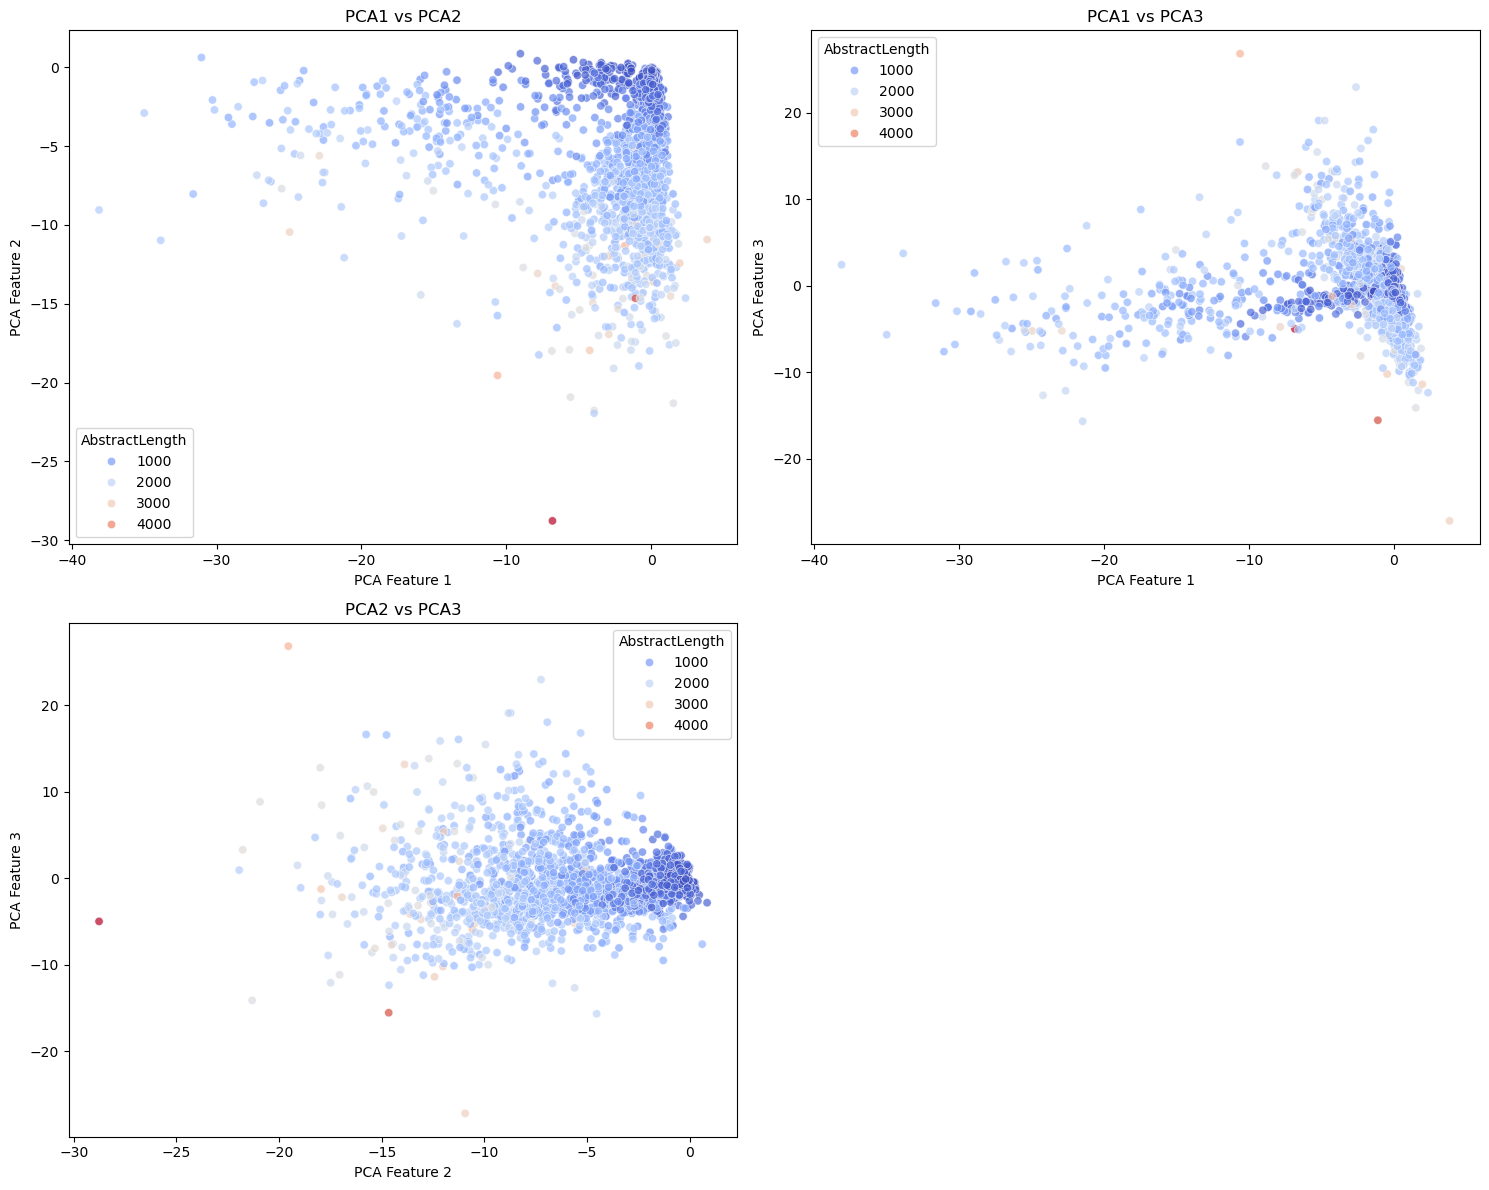

In [28]:
pca_plot(pandas_df, 'AbstractLength', 'coolwarm')

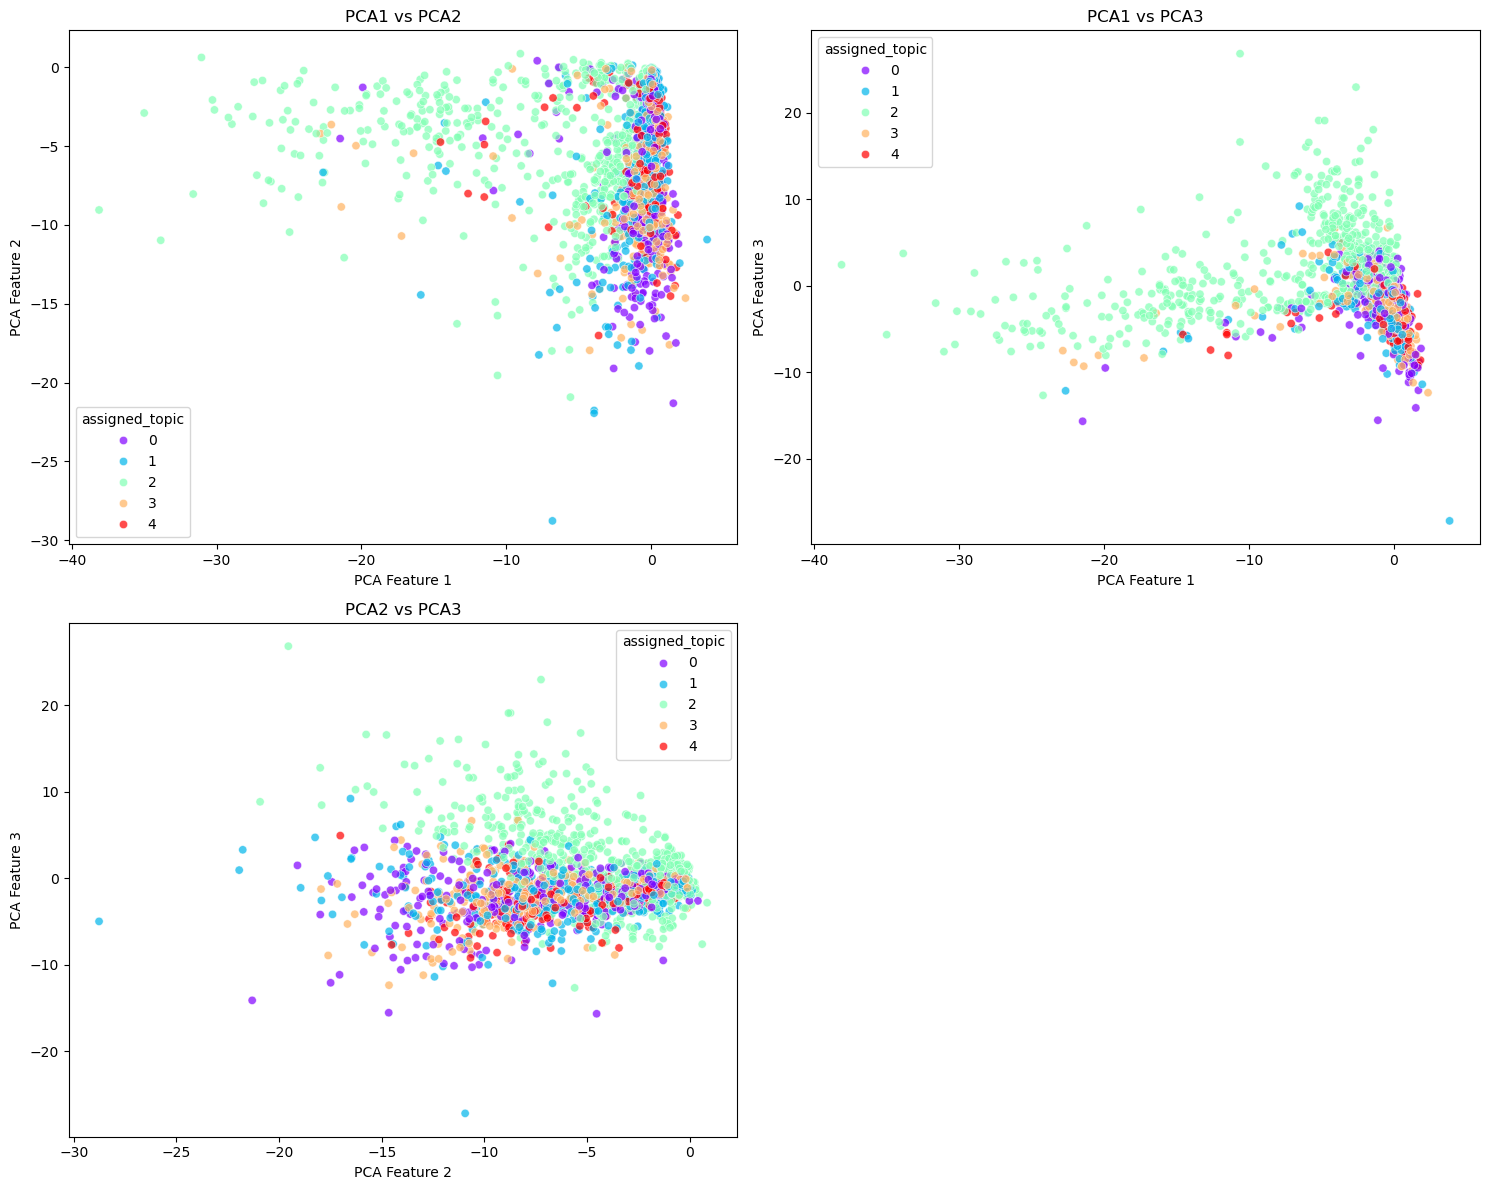

In [29]:
pca_plot(output_df, 'assigned_topic', 'rainbow')

# Save results classification

In [19]:
import os
from pyspark.sql.functions import expr, col, array_max
import datetime

# Create the folder if it doesn't exist
output_folder = os.path.join(path, '/Classification_results')
os.makedirs(output_folder, exist_ok=True)

# Save the list of articles (pmid + topic assigned)
date = datetime.datetime.now().strftime("%Y-%m-%d")
articles_output_path = os.path.join(output_folder, f'articles_with_topics_LDA_10_{date}.csv')
output_df.to_csv(articles_output_path, index=False)
# Save the table topics_df
topics_output_path = os.path.join(output_folder, f"topics_df_LDA_10_{date}.csv")
topics_terms.to_csv(topics_output_path, index = False)
